<b> <font size="+2.5"> Transcriptomic Age Acceleration
 </b> </font> <br>

Date: 2024-01-04 <br>
Author: ASF

# Load libraries

In [1]:
### Set up
suppressPackageStartupMessages({
library(tidyverse)
library(readxl)
library(dplyr)
library(ggplot2)
library(edgeR)
})

# Format age-dependent genes (identified by Lin et al. 2021)

In [2]:
# doi: 10.1038/s41380-020-0834-1
# load Suppl.Table 6 containing the age-related genes and their weights - BA11 (76 genes)

BA11_age_genes <- as.data.frame(read_excel("../external_datasets/Lin_et_al._weights_from_author.xlsx", sheet = "BA11"))
colnames(BA11_age_genes)[1] <- 'ID'
dim(BA11_age_genes)
head(BA11_age_genes)

[1] 76  2

,ID,Coefficient
,<chr>,<dbl>
1,ECM1,0.033219384
2,PADI2,0.021867525
3,SDC3,-0.039084255
4,FAM5C,-0.128512729
5,MIR29C,0.041337565
6,EGR2,0.005970537


In [3]:
# some of the gene names are not in the correct format
# FAM5C -> BRINP3; # KIAA0317 -> AREL1; # C5orf13 -> NREP; # GPR116 -> ADGRF5; # RABL5 -> IFT22

# correct gene names
BA11_age_genes$ID[BA11_age_genes$ID == 'FAM5C'] <- 'BRINP3'
BA11_age_genes$ID[BA11_age_genes$ID == 'KIAA0317'] <- 'AREL1'
BA11_age_genes$ID[BA11_age_genes$ID == 'C5orf13'] <- 'NREP'
BA11_age_genes$ID[BA11_age_genes$ID == 'GPR116'] <- 'ADGRF5'
BA11_age_genes$ID[BA11_age_genes$ID == 'RABL5'] <- 'IFT22'

In [4]:
# read in the gene information from adata object to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')
head(gene_names_ensembl)

,ID,ensembl
,<chr>,<chr>
1,AL627309.1,ENSG00000238009
2,AL627309.5,ENSG00000241860
3,LINC01409,ENSG00000237491
4,LINC01128,ENSG00000228794
5,LINC00115,ENSG00000225880
6,FAM41C,ENSG00000230368


In [5]:
BA11_age_genes_mapped <- merge(BA11_age_genes, gene_names_ensembl, by='ID')
head(BA11_age_genes_mapped)
dim(BA11_age_genes_mapped) # -> two age-dependent genes are not present in adata object

,ID,Coefficient,ensembl
,<chr>,<dbl>,<chr>
1,ADCY2,-0.02867042,ENSG00000078295
2,ADGRF5,-0.02698491,ENSG00000069122
3,ALDH1A1,-0.02016049,ENSG00000165092
4,ANXA4,0.05988246,ENSG00000196975
5,APC,-0.01037582,ENSG00000134982
6,APLF,-0.10471965,ENSG00000169621


[1] 74  3

# Read in meta data

In [6]:
# read in summarized meta data (from folder 04_selection_of_covariates; script 02_Selection_of_covariates)
meta_data <- read_excel('../datasets/summarized_meta_data_anonym_labels.xlsx', col_names = TRUE)
meta_data <- meta_data %>% select(c('Donor', 'Disease_Status', 'Sex', 'Age', 'pH', 'RIN', 'PMI', 'lib_batch', 'PC1')) 
meta_data <- as.data.frame(meta_data)
meta_data$Disease_Status <- factor(meta_data$Disease_Status, levels=c('Controls', 'Cases'))
head(meta_data)

,Donor,Disease_Status,Sex,Age,pH,RIN,PMI,lib_batch,PC1
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,s1,Cases,Male,51,6.62,7.5,18.0,15,-1.377918
2,s2,Cases,Male,64,6.60,7.6,24.0,15,-18.667621
3,s3,Cases,Female,66,6.52,8.1,12.5,10,-4.241909
4,s4,Cases,Male,40,6.20,7.6,21.5,13,-10.519050
5,s5,Cases,Male,55,6.34,6.4,72.0,5,-36.091387
6,s6,Controls,Female,33,6.77,7.7,24.0,13,21.016439


# Read in full pseudobulk counts object and normalize

In [7]:
# read in full pseudobulk counts object
# to obtain full pseudobulk counts object see script 03_Selection_of_covariates
load("../datasets/full_pseudobulk_counts.RData")

In [8]:
# Keep only genes expressed with >= 10 counts in more than specific percentage (60%) of samples
full_bulk_filt  <- full_bulk_counts[rowSums(full_bulk_counts >= 10) > 60,]
dim(full_bulk_counts)
dim(full_bulk_filt)

[1] 26195    87

[1] 22711    87

In [9]:
# Generate DGEList object (edgeR), and normalize
DGE <- DGEList(as.data.frame(full_bulk_filt), samples = meta_data)

# Normalization factor
# Calculate normalization factors to scale the raw library sizes.
# default method: TMM weighted trimmed mean of M-values proposed by Robinson and Oshlack (2010)
DGE <- calcNormFactors(DGE)

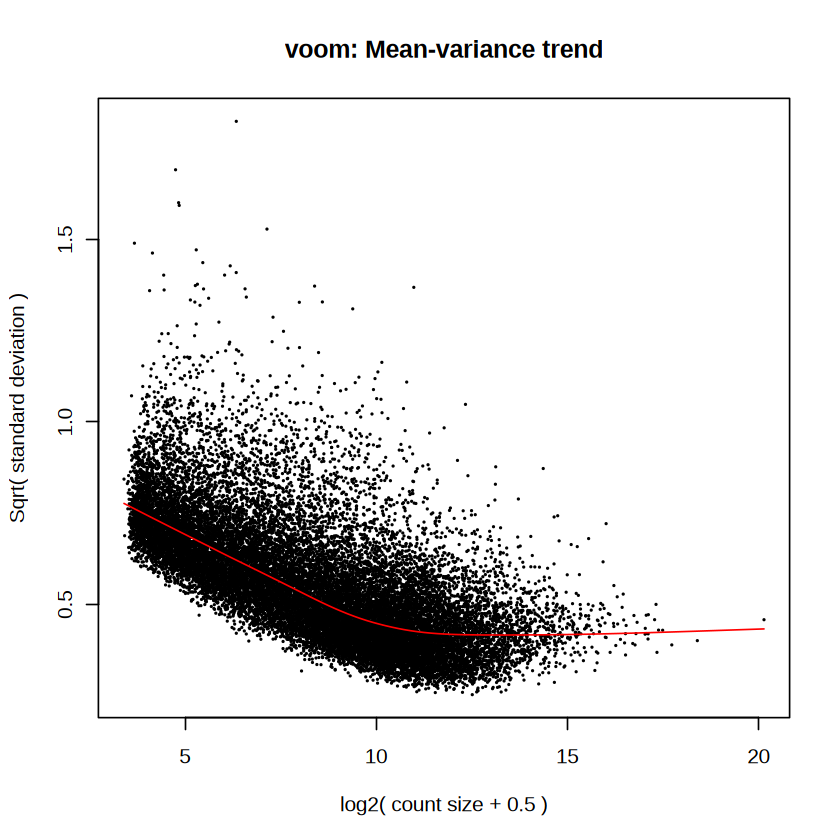

In [10]:
# Voom transformation and calculation of variance weights

#What is voom doing?
#Counts are transformed to log2 counts per million reads (CPM), where “per million reads” is defined based on the normalization factors we calculated earlier
#A linear model is fitted to the log2 CPM for each gene, and the residuals are calculated
#A smoothed curve is fitted to the sqrt(residual standard deviation) by average expression (see red line in plot above)
#The smoothed curve is used to obtain weights for each gene and sample that are passed into limma along with the log2 CPMs.

# specify model to fitted

#design matrix with rows corresponding to samples and columns to coefficients to be estimated. Defaults to the unit vector meaning that samples are treated as replicates.

des <- "~ Disease_Status + Sex + Age + pH + RIN + PMI + lib_batch +PC1"

mm <- model.matrix(as.formula(des), data = DGE$samples)


# voom transformation
DGE_voom <- voom(DGE, design=mm, plot = T)

# Calculate transcriptomic age

In [11]:
#filter counts for age-dependent genes identified by Lin et al.
counts_transc_age <- DGE_voom$E[rownames(DGE_voom$E) %in% BA11_age_genes_mapped$ensembl, ]  
dim(counts_transc_age)
# -> 73 out of 76 genes are expressed

[1] 73 87

In [12]:
# which genes are not expressed:
setdiff(BA11_age_genes$ID, BA11_age_genes_mapped$ID)
BA11_age_genes_mapped[BA11_age_genes_mapped$ensembl == setdiff(BA11_age_genes_mapped$ensembl, rownames(counts_transc_age)),]$ID

[1] "MIR29C" "KCNA6"

[1] "APLNR"

In [13]:
#calculate molecular age
# expression of gene * coeffcient - summed for all genes
mol_age <- as.data.frame(matrix(ncol=2, nrow=87))
colnames(mol_age) <- c('individual', 'mol_age')
mol_age$individual <- colnames(counts_transc_age)

for (individual in colnames(counts_transc_age)){
  tmp <- as.data.frame(counts_transc_age[,individual])
  tmp$ensembl <- rownames(counts_transc_age)
  colnames(tmp)[1] <- c('expression')
  tmp <- merge(tmp, BA11_age_genes_mapped, by='ensembl')
  tmp$Coefficient <- as.numeric(tmp$Coefficient)
  tmp$`expr*coef` <- tmp$expression*tmp$Coefficient
  mol_age[mol_age$individual == individual,][2] <- sum(tmp$`expr*coef`)
}

In [14]:
# combine mol_age with meta_data
meta_data <- cbind(meta_data, mol_age)

# re-scale molecular age
#fit linear regression between chronological age (Y) and molecular age (X) to re-scale the unit of molecular age back to the unit of chronological age by year

mol_age_adjust <- lm(meta_data$mol_age ~ meta_data$Age)
# y= k*x + d
# x= (y-d)/k
# k=coefficient[2] (slope); d = coefficient[1] (intercept)

meta_data$mol_age_rescaled <- (mol_age$mol_age - mol_age_adjust$coefficients[1] )/mol_age_adjust$coefficients[2]

## Fig. 7a

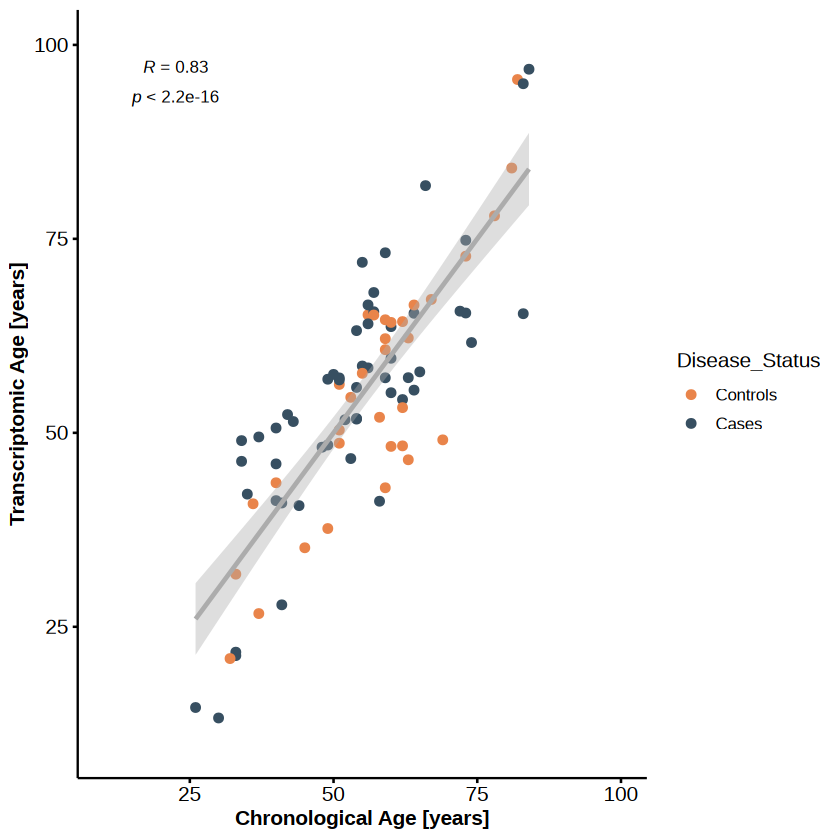

In [15]:
library("ggpubr")
ggscatter(meta_data, x = "Age", y = "mol_age_rescaled", color= 'Disease_Status',
          palette = c("#e9844a", "#374f61"), add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, legend='right', cor.method = "pearson", 
          add.params = list(color = "#acacac", fill = "#acacac"),  xlab = "Chronological Age [years]", 
          ylab = "Transcriptomic Age [years]", cor.coeff.args = list(label.y = 95, label.x= 15, label.sep = "\n", size=3.5) ) + 
theme(axis.title = element_text(face="bold")) + ylim(10,100) + xlim(10,100) 

In [16]:
ggsave("../figures/Final_Pearson_re-scaled_Mol_Age_Lin_et_al.pdf", plot = last_plot(), width = 5, height = 4)

# Supplementary Table 11 - Calculate transcriptomic age acceleration

In [17]:
# calculate covariate-corrected AgeAccell
# transcriptomic age acceleration was calculated by regressing transcriptomic age estimates on age-at-death controlling or lib_batch and saving the residuals 
AgeAccel <- lm(mol_age_rescaled ~ Age + lib_batch, data=meta_data)
meta_data$AgeAccel <- AgeAccel$residuals

In [18]:
# Multiple linear regression to examine Disease Status association with transcriptomic age acceleration controlling for Sex,  pH, RIN, PMI and PC1
casecontrol_AgeAccel <- lm(AgeAccel ~ PC1 + RIN + PMI + pH + Sex + Disease_Status,
                           data = meta_data)

In [19]:
summary(casecontrol_AgeAccel)


Call:
lm(formula = AgeAccel ~ PC1 + RIN + PMI + pH + Sex + Disease_Status, 
    data = meta_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.5259  -4.2045   0.5042   5.5741  22.5959 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)         -22.55791   28.73853  -0.785   0.4348  
PC1                  -0.03429    0.04633  -0.740   0.4614  
RIN                   0.41080    0.89456   0.459   0.6473  
PMI                  -0.07705    0.05746  -1.341   0.1837  
pH                    2.67171    4.85548   0.550   0.5837  
SexMale               2.84457    1.70972   1.664   0.1001  
Disease_StatusCases   4.24338    1.80320   2.353   0.0211 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.663 on 80 degrees of freedom
Multiple R-squared:  0.123,	Adjusted R-squared:  0.05724 
F-statistic:  1.87 on 6 and 80 DF,  p-value: 0.09612


In [20]:
lm_age_accel <- as.data.frame(summary(casecontrol_AgeAccel)$coefficients)
lm_age_accel <- rownames_to_column(lm_age_accel, "Predictors")
lm_age_accel$Estimate <- round(lm_age_accel$Estimate, digits=3)
lm_age_accel$`Std. Error` <- round(lm_age_accel$`Std. Error`, digits=3)
lm_age_accel$`t value` <- round(lm_age_accel$`t value`, digits=3)
lm_age_accel$`Pr(>|t|)` <- round(lm_age_accel$`Pr(>|t|)`, digits=3)
colnames(lm_age_accel)[which(names(lm_age_accel) == 'Pr(>|t|)')] <- 'p-value'
lm_age_accel[nrow(lm_age_accel)+2,] <- NA
lm_age_accel[8,1] <- 'Observations'
lm_age_accel[8,2] <- length(meta_data$individual)
lm_age_accel[9,1] <- 'R2/R2 adj.'
lm_age_accel[9,2] <- paste0(round(summary(casecontrol_AgeAccel)$r.squared, digits=4), '/', round(summary(casecontrol_AgeAccel)$adj.r.squared, digits=4))

In [21]:
lm_age_accel

,Predictors,Estimate,Std. Error,t value,p-value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,(Intercept),-22.558,28.739,-0.785,0.435
2,PC1,-0.034,0.046,-0.740,0.461
3,RIN,0.411,0.895,0.459,0.647
4,PMI,-0.077,0.057,-1.341,0.184
5,pH,2.672,4.855,0.550,0.584
6,SexMale,2.845,1.710,1.664,0.100
7,Disease_StatusCases,4.243,1.803,2.353,0.021
8,Observations,87,NA,NA,NA
9,R2/R2 adj.,0.123/0.0572,NA,NA,NA


In [22]:
library(writexl)
write_xlsx(lm_age_accel, '../results/transcriptomic_age/lm_transc_age_accel.xlsx', col_names = TRUE)
write_xlsx(meta_data, '../results/transcriptomic_age/meta_data_w_transc_age.xlsx', col_names = TRUE)

# SessionInfo

In [26]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.6.0    edgeR_4.0.1     limma_3.58.1    readxl_1.4.3   
 [5] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.0   dplyr_1.1.3    
 [9] purrr_1.0.2     readr_2.1.4     tidyr_1.3.0     tibble_3.2.1   
[13]